In [1]:
#https://storage.googleapis.com/kaggle-forum-message-attachments/346809/9660/tracklet_seeding.py
import os
from trackml.score  import score_event
from sklearn.cluster.dbscan_ import dbscan
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



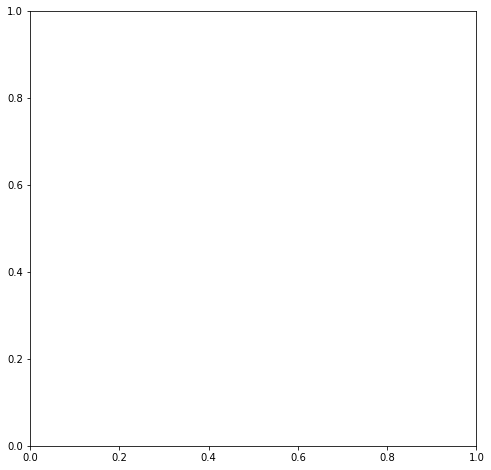

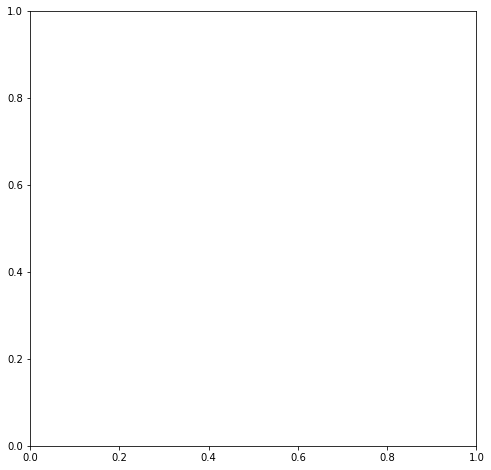

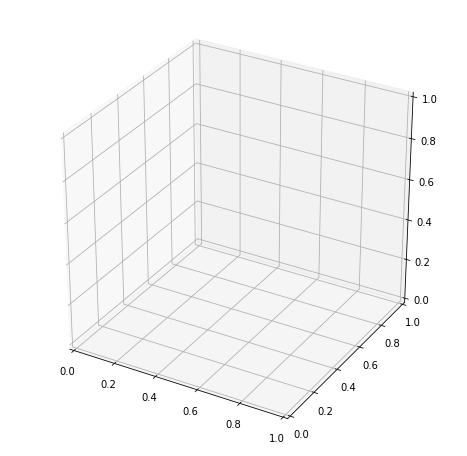

In [2]:


fig1 = plt.figure(figsize=(8,8))
ax1  = fig1.add_subplot(111, )
fig1.patch.set_facecolor('white')

fig2 = plt.figure(figsize=(8,8))
ax2  = fig2.add_subplot(111, )  #projection='3d')
fig2.patch.set_facecolor('white')


fig3d1 = plt.figure(figsize=(8,8))
ax3d1  = fig3d1.add_subplot(111, projection='3d')
fig3d1.patch.set_facecolor('white')


def plot3d_particles(ax3d, particle_ids, p, ar,r,zr, z,min_length=3):
    num_particle_ids = len(particle_ids)
    for n in range(0,num_particle_ids,1):
        particle_id = particle_ids[n]
        t = np.where(p==particle_id)[0]
        if len(t)<min_length: continue

        t = t[np.argsort(np.fabs(z[t]))]
        ax3d1.plot(ar[t], r[t], zr[t],'.-',  color=[0.75,0.75,0.75], markersize=0,  linewidth=1)


def plot_particles(ax, particle_ids, p, ar, zr, z,min_length=3):
    num_particle_ids = len(particle_ids)
    for n in range(0,num_particle_ids,1):
        particle_id = particle_ids[n]
        t = np.where(p==particle_id)[0]
        if len(t)<min_length: continue

        t = t[np.argsort(np.fabs(z[t]))]
        ax.plot(ar[t], zr[t],'.-',  color=[0.75,0.75,0.75], markersize=0,  linewidth=1)


        
#https://www.kaggle.com/cpmpml/a-faster-python-scoring-function
def score_event_fast_3(truth, submission):
    truth = truth[['hit_id', 'particle_id', 'weight']].merge(submission, how='left', on='hit_id')
    truth['count_both'] = truth.groupby(['track_id', 'particle_id']).hit_id.transform('count')    
    truth['count_particle'] = truth.groupby(['particle_id']).hit_id.transform('count')
    truth['count_track'] = truth.groupby(['track_id']).hit_id.transform('count')

    score = truth[(truth.count_both > 0.5*truth.count_particle) & (truth.count_both > 0.5*truth.count_track)].weight.sum()
    results = truth
    return score, results 

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def create_df_submission(event_id, df, labels):
    submission = pd.DataFrame(columns=['event_id', 'hit_id', 'track_id'],
        data=np.column_stack(([int(event_id),]*len(df), df.hit_id.values, labels))
    ).astype(int)
        
    return submission    

In [3]:

def study_dbscan_for_tracklet_seeding():

    ## load an event ---
    event_id = '1003'

    data_dir  = '../../../input/train_100_events'
    csv_dir = '../../../input/'
    
    particles = pd.read_csv(os.path.join(data_dir, 'event00000%s-particles.csv'%event_id))
    hits      = pd.read_csv(os.path.join(data_dir, 'event00000%s-hits.csv' %event_id))
    truth     = pd.read_csv(os.path.join(data_dir, 'event00000%s-truth.csv'%event_id))
    
    helix1 = pd.read_csv(os.path.join(csv_dir, 'event_%s_labels_train_helix1.csv' %event_id)).label.values
    #helix2 = pd.read_csv(os.path.join(csv_dir, 'event_%s_labels_train_helix2.csv' %event_id)).label.values
    #helix2 = pd.read_csv(os.path.join(csv_dir, 'event_%s_labels_train_helix2.csv' %event_id)).label.values
    helix2 = pd.read_csv(os.path.join(csv_dir, 'hough_transform_%s.csv' %event_id)).label.values
    
    
    #helix2 = pd.read_csv(os.path.join(csv_dir, 'event_%s_labels_train_final.csv' %event_id)).label.values
    #cells = pd.read_csv(data_dir + '/event%s-cells.csv'%event_id)

    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')
    
    #--------------------------------------------------------
    df = truth.copy()
    df = df.assign(r   = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(d   = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(a   = np.arctan2(df.y, df.x))
    df = df.assign(cosa= np.cos(df.a))
    df = df.assign(sina= np.sin(df.a))
    df = df.assign(phi = np.arctan2(df.z, df.r))
    df = df.assign(momentum = np.sqrt( df.px**2 + df.py**2 + df.pz**2 ))
    df.loc[df.particle_id==0,'momentum']=0

    df = df.loc[np.absolute(df.z) > 500] # consider dataset subset
    df = df.loc[(df.r<100)  ]
    helix1 = helix1[df.index.values]
    helix2 = helix2[df.index.values]
    
    
    
    N = len(df)

    layer_id = df['layer_id'].values.astype(np.float32)
    momentum = df['momentum'].values.astype(np.float32)
    p = df[['particle_id']].values.astype(np.int64)
    x,y,z,r,a,cosa,sina,phi = df[['x', 'y', 'z', 'r', 'a', 'cosa', 'sina', 'phi']].values.astype(np.float32).T

    particle_ids = np.unique(p)
    particle_ids = particle_ids[particle_ids!=0]
    num_particle_ids = len(particle_ids)

    # do xxx =======================================
    #color = plt.cm.hsv( (z-z.min()) / (z.max()-z.min()))
    color = plt.cm.hsv( (layer_id-layer_id.min()) / (layer_id.max()+1-layer_id.min()))

    plot3d_particles(ax3d1, particle_ids, p, a,r,z, z)
    ax3d1.scatter(a, r,  z, c=color, s=64, edgecolors='none')
    #plt.show()
    
    # do dbscan here =======================================
    dj=0
    di=0
    EPS=1e-12
    #if 1:

    candidates = []
    for dj in np.arange(-30, 30+EPS, 10):
        for di in np.arange(-0.003, 0.003+EPS, 0.00025):
            ar = a +  di*r
            zr = (z+dj)/r  *0.1
            data2 = np.column_stack([ar,zr])

            _,l = dbscan(data2, eps=0.0025, min_samples=1,)
            track_ids = np.unique(l)
            track_ids = track_ids[track_ids!=0]
            neigbour = [ np.where(l==t)[0] for t in track_ids]

            unique,inverse,c = np.unique(l,return_counts=True,return_inverse=True)
            unique = unique[unique!=0]
            c = c[inverse]
            c[l==0] = 0

            for u in unique:
                candidate = np.where(l==u)[0]
                candidates.append(candidate)

                
    #---
    #<todo>
    #fix angle discontinunity problem here ...


    #-----
    #sort
    count = np.array([len(candidate) for candidate in candidates])
    sort = np.argsort(-count)
    candidates = [candidates[s] for s in sort]


    #show
    max_label=1
    label = np.zeros(N,np.int32)
    count = np.zeros(N,np.int32)

    for candidate in candidates:
        n = candidate
        L = len(n)
        #print(L)


        #---- filtering (secret sauce) ----------
        #if L<3: continue
        n = n[np.argsort(np.fabs(z[n]))]

        layer_id0 = layer_id[n[:-1]]
        layer_id1 = layer_id[n[1: ]]
        ld = layer_id1-layer_id0
        if np.any(ld>2): continue

        m = count[n].max()
        if L<m: continue

        #---- filtering ----------------------

        count[n]=L
        label[n]=max_label
        max_label += 1

        ## show:
        if L>=3:
            #c = np.random.uniform(0,1,3)#[0,0,0]
            c = [0,0,0]

            #ax3d1.clear()
            #plot_particles(ax3d1, particle_ids, p, a,r,zr, z)
            #ax3d1.scatter(ar, r,  zr, c=color, s=64, edgecolors='none')
            ax3d1.plot(a[n],r[n], z[n],'.-',  color=c, markersize=5,  linewidth=1)
            #ax3d1.plot(a[[n[0],n[-1]]],r[[n[0],n[-1]]],zr[[n[0],n[-1]]],'-',  color=[1,0,0], markersize=5,  linewidth=1)



        #plt.pause(0.01)
        #plt.waitforbuttonpress(-1)
        #plt.show()

    ##-###################################################################################3
    submission = pd.DataFrame(columns=['event_id', 'hit_id', 'track_id'],
        data=np.column_stack(([int(event_id),]*len(df), df.hit_id.values, label))
    ).astype(int)
    score1 = score_event(df, submission)
    score2, results = score_event_fast_3(df, submission)

    #print results
    max_score = df.weight.sum()
    print('max_score = df.weight.sum() = %0.5f'%max_score)
    print('score1= %0.5f  (%0.5f)'%(score1*max_score,score1))
    print('score2= %0.5f  (%0.5f)'%(score2,score2/max_score))


    plt.show()
    print('end')
    exit(0)

    
    




In [4]:
if __name__ == '__main__':
    
    study_dbscan_for_tracklet_seeding()




max_score = df.weight.sum() = 0.20614
score1= 0.18601  (0.90237)
score2= 0.18601  (0.90237)
end
